In [1]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.optimize import minimize
from jobshop.params import JobShopRandomParams, JobShopParams
from jobshop.heurstic.decoder import Decoder
from jobshop.heurstic.brkga import BRKGA
from jobshop.heuristic.evaluation import calc_makespan, calc_tails
from jobshop.heuristic.local_search import get_critical, local_search

In [2]:
class LSDecoder(Decoder):
    
    def build_graph(self, pheno):
        graph = super().build_graph(pheno)
        calc_tails(graph)
        get_critical(graph)
        return local_search(graph)

In [3]:
params = JobShopRandomParams(10, 10, t_span=(0, 20), seed=12)  # 10, 10 seed 12 known optimal solution 153

In [4]:
class JobShopProblem(ElementwiseProblem):
    
    def __init__(self, params: JobShopParams):
        self.params = params
        n_var = 0
        for j, machines in self.params.seq.items():
            n_var = n_var + len(machines)
        xl = np.zeros(n_var)
        xu = np.ones(n_var)
        self.decoder = LSDecoder(
            self.params.machines, self.params.jobs,
            self.params.p_times, self.params.seq
        )
        super().__init__(elementwise=True, n_var=n_var, n_obj=1, xl=xl, xu=xu)
    
    def _evaluate(self, x, out, *args, **kwargs):
        z, C = self.decoder.decode(x)
        out["pheno"] = z
        out["hash"] = hash(str(z))
        out["F"] = C

In [5]:
class DuplicatesEncoder(ElementwiseDuplicateElimination):
    
    def __init__(self, x_tol=1e-3) -> None:
        super().__init__()
        self.x_tol = x_tol

    def is_equal(self, a, b):
        same_pheno = a.get("hash") == b.get("hash")
        diff_x = a.get("X") - b.get("X")
        dist_x = np.sqrt(diff_x.dot(diff_x))
        return same_pheno and dist_x <= self.x_tol * len(diff_x)

In [6]:
brkga = BRKGA(
    pop_size=100,
    perc_elite=0.15,
    perc_mutants=0.15,
    bias=0.8,
    eliminate_duplicates=DuplicatesEncoder(1e-2),
)
problem = JobShopProblem(params)

In [7]:
res = minimize(problem, brkga, ("n_gen", 200), verbose=True, seed=12)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  2.169100E+02 |  1.820000E+02
     2 |      185 |  2.113200E+02 |  1.820000E+02
     3 |      270 |  2.138300E+02 |  1.800000E+02
     4 |      355 |  2.103000E+02 |  1.710000E+02
     5 |      440 |  2.086000E+02 |  1.710000E+02
     6 |      525 |  2.038400E+02 |  1.710000E+02
     7 |      610 |  2.084400E+02 |  1.710000E+02
     8 |      695 |  2.034300E+02 |  1.710000E+02
     9 |      780 |  2.060000E+02 |  1.710000E+02
    10 |      865 |  2.041200E+02 |  1.710000E+02
    11 |      950 |  2.035800E+02 |  1.710000E+02
    12 |     1035 |  2.013600E+02 |  1.700000E+02
    13 |     1120 |  2.008200E+02 |  1.700000E+02
    14 |     1205 |  2.023000E+02 |  1.700000E+02
    15 |     1290 |  2.001000E+02 |  1.690000E+02
    16 |     1375 |  2.000300E+02 |  1.690000E+02
    17 |     1460 |  2.007700E+02 |  1.690000E+02
    18 |     1545 |  1.957600E+02 |  1.680000E+02
    19 |     1630 |  2.053200E+02 |  1.680000E+02


In [8]:
graph = problem.decoder.build_graph_from_string(res.X)

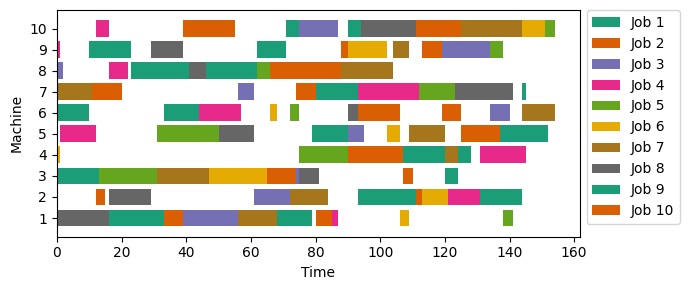

In [9]:
graph.plot()